## Initialisation

In [1]:
from polymorph_s2df import *
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

def render(shape, bounds=(-3, 3), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    vec_is_inside = (lambda x: 1 - shape.is_inside(x))
    plt.imshow(vec_is_inside(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])


def render_distance(shape, bounds=(-3, 3), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    sdf = (shape.distance)

    values = sdf(grid_points).reshape(n, n)
    
    fig1, ax2 = plt.subplots(layout='constrained')

    levels = jnp.linspace(-5, 5, 41)

    ax2.axis('equal')
    ax2.contourf(X, Y, values, levels=levels, cmap="PRGn", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])
    ax2.contour(X, Y, values, levels=levels, colors="k", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

class S(Shape):
    """A shape apater for segments"""
    def __init__(self, segment):
        self.segment = segment

    def distance(self, p):
        distance, _ = jax.vmap(self.segment.distance_and_mask)(p)
        return distance

In [2]:
class JoinedSegments(Shape):
    def __init__(self, segments):
        self.segments = segments

        self.orientation_sign = jnp.sign(
            jnp.sum(jnp.array([jnp.cross(segment.start, segment.end) for segment in segments]))
        )

    def __repr__(self):
        return (
            f"JoinedSegments(\n{"\n".join(indent_shape(seg) for seg in self.segments)}\n)"
        )

    def distance(self, p):
        return jax.vmap(self.distance_)(p)

    def distance_(self, p):
        # The gist of the algorithm is to combine the distance to each segment
        # and to each point between the segments. Segments cannot apply to the
        # whole space, so we need to combine them with "masks".

        # We use a mask instead of an if condition as jax jit does not support it

        distances_and_masks = [
            segment.distance_and_mask(p) for segment in self.segments
        ]

        current_distance, current_mask = distances_and_masks[0]
        minimum_distance = jnp.abs(current_distance)

        # We combine the distance for all the segments
        for distance, mask in distances_and_masks[1:]:
            distance = jnp.abs(distance)

            # first we handle the case where the distance can be defined by
            # its distance to both segment
            current_distance = jnp.minimum(
                minimum_distance * mask, distance * current_mask
            )

            # if only one of the segment can apply we use it
            current_distance += minimum_distance * (1 - mask) + distance * (
                1 - current_mask
            )

            current_mask = 1 - ((1 - mask) * (1 - current_mask))
            minimum_distance = current_distance

        return minimum_distance 

In [3]:
class JoinedSegmentsWithPoint(Shape):
    def __init__(self, segments):
        self.segments = segments
        self.starts = [segment.start for segment in segments]

        # TODO: Improve this code - some of it should be in the Segment class
        self.orientation_sign = jnp.sign(
            jnp.sum(jnp.array([jnp.cross(segment.start, segment.end) for segment in segments]))
        )

    def __repr__(self):
        return (
            f"ClosedPath(\n{"\n".join(indent_shape(seg) for seg in self.segments)}\n)"
        )

    def _min_distance_to_points(self, p):
        dist = jnp.linalg.norm(p - self.starts[0])
        for point in self.starts[1:]:
            dist = jnp.minimum(dist, jnp.linalg.norm(p - point))
        return dist

    def distance(self, p):
        return jax.vmap(self.distance_)(p)

    def distance_(self, p):
        # The gist of the algorithm is to combine the distance to each segment
        # and to each point between the segments. Segments cannot apply to the
        # whole space, so we need to combine them with "masks".

        # We use a mask instead of an if condition as jax jit does not support it

        distances_and_masks = [
            segment.distance_and_mask(p) for segment in self.segments
        ]

        current_distance, current_mask = distances_and_masks[0]
        minimum_distance = jnp.abs(current_distance)

        # We combine the distance for all the segments
        for distance, mask in distances_and_masks[1:]:
            distance = jnp.abs(distance)

            # first we handle the case where the distance can be defined by
            # its distance to both segment
            current_distance = jnp.minimum(
                minimum_distance * mask, distance * current_mask
            )

            # if only one of the segment can apply we use it
            current_distance += minimum_distance * (1 - mask) + distance * (
                1 - current_mask
            )

            current_mask = 1 - ((1 - mask) * (1 - current_mask))
            minimum_distance = current_distance

        points_distance = self._min_distance_to_points(p)
        minimum_distance = (
            jnp.minimum(minimum_distance, points_distance)
            + (1 - current_mask) * points_distance
        )

       
        return minimum_distance


In [4]:
def joined_segments_polygon(vertices, with_points=False):
    segments = [
        LineSegment(vertices[i], vertices[(i + 1) % len(vertices)])
        for i in range(len(vertices))
    ]
    return JoinedSegments(segments) if not with_points else JoinedSegmentsWithPoint(segments)

# Building polygons for SDFs

Polygons for SDFs are not obvious to build - especially if you want to expand them to generic paths (including arcs and quadratic Béziers).

The trick is to decompose the polygon into its basic parts:
* segments
* points

The distance to the polygon will be the distance to any of these parts.

## Distance to a segment

A segment does not have a defined distance well defined for the hole plane - for instance, we can plot the distance to this segment here.

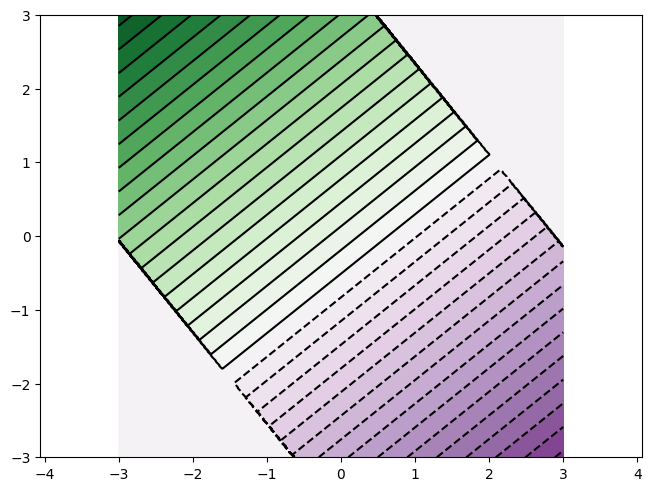

In [5]:
render_distance(S(LineSegment(p(2, 1.1), p(-1.6, -1.8))))

You can see that the outside is set at 0. It actually also returns a mask value which defines if the segment knows or not anything about the distance to a point.

We can then combine all the segments such that we take the minimum where they are both defined, and the value where only one is defined. Note that we use a mask value that we multiply instead of a conditional, in order for jax to be able to jit and grad everything.

If we combined it we would obtain something like that:

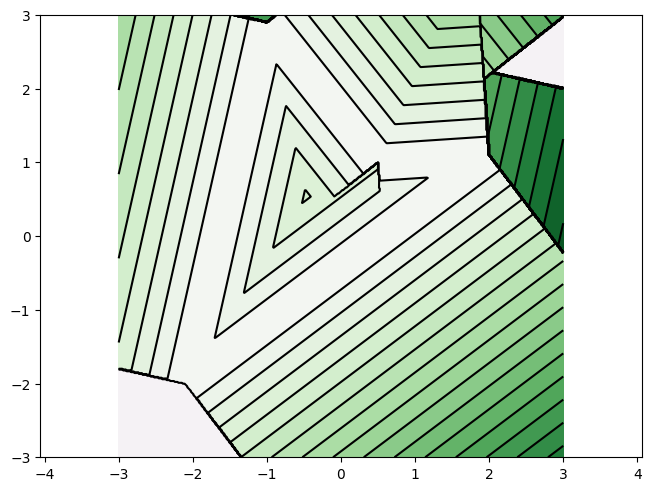

In [6]:
render_distance(joined_segments_polygon([p(2, 1.1), p(-2.1, -2), p(-1, 2.9), p(0.5, 1)]), [-3, 3])

The base of the triangle is definitely here - but we have issues around the corners - we need to add the distance to the corner points.

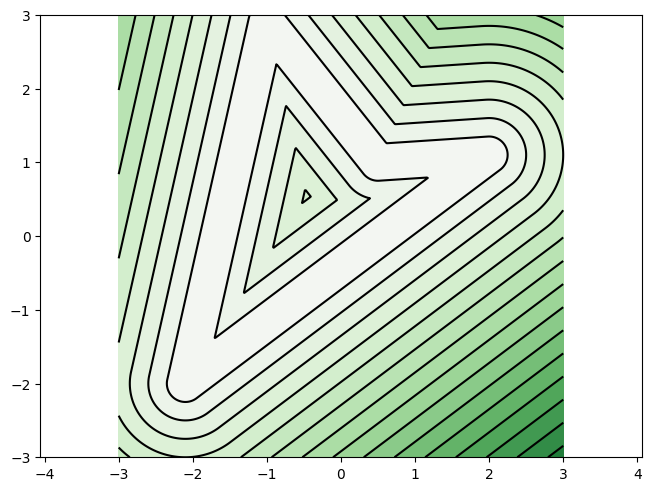

In [7]:
render_distance(joined_segments_polygon([p(2, 1.1), p(-2.1, -2), p(-1, 2.9), p(0.5, 1)], True), [-3, 3])

Now we need to figure out if a point is within the shape or not. For now, I have implemented an algorithm that checks which point or segment we are the closest to and decide of the sign according that segment or point.

In that case we also need to decide what to do if we are closest to a point. Points that are on a concave angle are "inside points" and points on a convexe one are outside.

I have convinced myself visually that it works (for polygons at least). This part should probably be implemented with a winding number algorithm (with a dipole implementation when far enough).

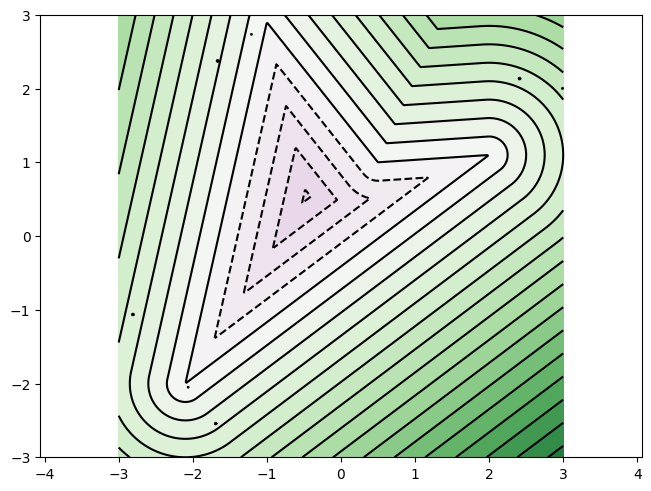

In [8]:
render_distance(polygon([p(2, 1.1), p(-2.1, -2), p(-1, 2.9), p(0.5, 1)]), [-3, 3])